In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torchvision.utils import make_grid
from autoencoder import *
from torch.optim import Adam
import json
from torchsummary import summary

# Load in Data Functions and Paths

In [9]:
path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Your initial path
new_path = os.path.dirname(path)  # Remove the last folder

# Add the root directory (PARCTorch) to the system path
sys.path.append(new_path)
from data.normalization import compute_min_max

data_dirs = [
    "/project/vil_baek/data/physics/PARCTorch/HMX/train",
    "/project/vil_baek/data/physics/PARCTorch/HMX/test",
]
output_file = new_path + "/data/hmx_min_max.json"
compute_min_max(data_dirs, output_file)

from torch.utils.data import DataLoader, random_split
import logging
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

# Example configuration for HMX dataset
data_dir_train = "/project/vil_baek/data/physics/PARCTorch/HMX/train"  # Replace with your actual train directory path
data_dir_test = "/project/vil_baek/data/physics/PARCTorch/HMX/test"  # Replace with your actual test directory path

# Path to the min_max.json file
min_max_path = os.path.join(new_path, "data", "hmx_min_max.json")  # Correct path

Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC/autoencoder
Total files to process: 91
Processed 91/91 files.
Channel-wise min values: [300.0, -1186907500.0, 0.0, 0.0, 0.0]
Channel-wise max values: [5000.0, 69721220000.0, 1.0, 7200.339, 7200.339]
Min and max values saved to '/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/data/hmx_min_max.json'.


# Create Data Loader for Training

In [3]:
n_ts = 2
batch_size = 4
validation_split = 0.05  # 20% for validation

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=n_ts-1,
    min_max_path=min_max_path,
    vflip_prob=0.5,
)

# Calculate the size of the validation set
validation_size = int(len(train_dataset) * validation_split)
train_size = len(train_dataset) - validation_size

# Perform the split
train_subset, val_subset = random_split(train_dataset, [train_size, validation_size])

# Create DataLoader for training and validation datasets
train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the training data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle validation data
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2025-06-05 21:36:48,387 [INFO] Starting data validation...
2025-06-05 21:36:48,389 [INFO] Validating .npy files...
Validating files: 100%|██████████| 58/58 [00:00<00:00, 462.96it/s]
2025-06-05 21:36:48,519 [INFO] Data validation completed successfully.
2025-06-05 21:36:48,520 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 58/58 [00:00<00:00, 801.49it/s]
2025-06-05 21:36:48,595 [INFO] Total samples in dataset: 812


# Define Autoencoder Architecture + Training

In [4]:
# where to save weights
save_path="/sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC/autoencoder"
weights_name="IRCAE_3_8_8_16_32_decoder"

# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes = [3, 8, 8, 16]
latent_dim = 32
encoder = Encoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)
decoder = Decoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)

#Loss Function
criterion = torch.nn.L1Loss().cuda()
# criterion = torch.nn.MSELoss().cuda()
# criterion = LpLoss(p=10).cuda()

# Define learning rate scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

#  training model
model = IRCAE(encoder, decoder, iso_reg=1.0) #optimizer, device, save_path, weights_name

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

log_dict = train_IR_autoencoder(model, optimizer, criterion, train_loader, val_loader, 
                             device=device, epochs=150, image_size=[128, 256], n_channels=3, 
                             scheduler=scheduler, noise_fn=add_random_noise, initial_max_noise=.16, reduce_on=10,
                             save_path=save_path, weights_name=weights_name)

/home/pdy2bw/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.91it/s]


Epoch 1: Training Loss: 0.3473 | Validation Loss: 0.3816

Epoch 2/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.41it/s]


Epoch 2: Training Loss: 0.3380 | Validation Loss: 0.3699

Epoch 3/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.42it/s]


Epoch 3: Training Loss: 0.3214 | Validation Loss: 0.0781

Epoch 4/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.57it/s]


Epoch 4: Training Loss: 0.0478 | Validation Loss: 0.0511

Epoch 5/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.45it/s]


Epoch 5: Training Loss: 0.0264 | Validation Loss: 0.0524

Epoch 6/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.97it/s]


Epoch 6: Training Loss: 0.0251 | Validation Loss: 0.0515

Epoch 7/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.88it/s]


Epoch 7: Training Loss: 0.0251 | Validation Loss: 0.0495

Epoch 8/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.19it/s]


Epoch 8: Training Loss: 0.0244 | Validation Loss: 0.0491

Epoch 9/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 36.16it/s]


Epoch 9: Training Loss: 0.0239 | Validation Loss: 0.0475

Epoch 10/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.50it/s]


Epoch 10: Training Loss: 0.0242 | Validation Loss: 0.0370

Epoch 11/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.87it/s]


Epoch 11: Training Loss: 0.0236 | Validation Loss: 0.0388

Epoch 12/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 24.66it/s]


Epoch 12: Training Loss: 0.0232 | Validation Loss: 0.0346

Epoch 13/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 35.01it/s]


Epoch 13: Training Loss: 0.0228 | Validation Loss: 0.0349

Epoch 14/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 26.73it/s]


Epoch 14: Training Loss: 0.0228 | Validation Loss: 0.0359

Epoch 15/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.33it/s]


Epoch 15: Training Loss: 0.0223 | Validation Loss: 0.0363

Epoch 16/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.71it/s]


Epoch 16: Training Loss: 0.0229 | Validation Loss: 0.0346

Epoch 17/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 36.04it/s]


Epoch 17: Training Loss: 0.0226 | Validation Loss: 0.0364

Epoch 18/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.67it/s]


Epoch 18: Training Loss: 0.0224 | Validation Loss: 0.0353

Epoch 19/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.51it/s]


Epoch 19: Training Loss: 0.0218 | Validation Loss: 0.0325

Epoch 20/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.95it/s]


Epoch 20: Training Loss: 0.0227 | Validation Loss: 0.0305

Epoch 21/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.46it/s]


Epoch 21: Training Loss: 0.0219 | Validation Loss: 0.0254

Epoch 22/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.63it/s]


Epoch 22: Training Loss: 0.0213 | Validation Loss: 0.0278

Epoch 23/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.13it/s]


Epoch 23: Training Loss: 0.0208 | Validation Loss: 0.0272

Epoch 24/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.98it/s]


Epoch 24: Training Loss: 0.0208 | Validation Loss: 0.0275

Epoch 25/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.31it/s]


Epoch 25: Training Loss: 0.0201 | Validation Loss: 0.0280

Epoch 26/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 31.84it/s]


Epoch 26: Training Loss: 0.0204 | Validation Loss: 0.0245

Epoch 27/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 37.28it/s]


Epoch 27: Training Loss: 0.0204 | Validation Loss: 0.0248

Epoch 28/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.48it/s]


Epoch 28: Training Loss: 0.0199 | Validation Loss: 0.0211

Epoch 29/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.03it/s]


Epoch 29: Training Loss: 0.0202 | Validation Loss: 0.0266

Epoch 30/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.87it/s]


Epoch 30: Training Loss: 0.0196 | Validation Loss: 0.0210

Epoch 31/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 29.81it/s]


Epoch 31: Training Loss: 0.0193 | Validation Loss: 0.0218

Epoch 32/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.51it/s]


Epoch 32: Training Loss: 0.0192 | Validation Loss: 0.0216

Epoch 33/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.63it/s]


Epoch 33: Training Loss: 0.0191 | Validation Loss: 0.0228

Epoch 34/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.82it/s]


Epoch 34: Training Loss: 0.0190 | Validation Loss: 0.0197

Epoch 35/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 35.51it/s]


Epoch 35: Training Loss: 0.0189 | Validation Loss: 0.0210

Epoch 36/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.10it/s]


Epoch 36: Training Loss: 0.0194 | Validation Loss: 0.0237

Epoch 37/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 35.29it/s]


Epoch 37: Training Loss: 0.0191 | Validation Loss: 0.0221

Epoch 38/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 35.61it/s]


Epoch 38: Training Loss: 0.0189 | Validation Loss: 0.0212

Epoch 39/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.93it/s]


Epoch 39: Training Loss: 0.0190 | Validation Loss: 0.0196

Epoch 40/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.45it/s]


Epoch 40: Training Loss: 0.0188 | Validation Loss: 0.0210

Epoch 41/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 31.15it/s]


Epoch 41: Training Loss: 0.0184 | Validation Loss: 0.0204

Epoch 42/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 36.32it/s]


Epoch 42: Training Loss: 0.0192 | Validation Loss: 0.0203

Epoch 43/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.71it/s]


Epoch 43: Training Loss: 0.0184 | Validation Loss: 0.0194

Epoch 44/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 25.35it/s]


Epoch 44: Training Loss: 0.0183 | Validation Loss: 0.0186

Epoch 45/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.98it/s]


Epoch 45: Training Loss: 0.0182 | Validation Loss: 0.0183

Epoch 46/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.09it/s]


Epoch 46: Training Loss: 0.0182 | Validation Loss: 0.0181

Epoch 47/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.80it/s]


Epoch 47: Training Loss: 0.0178 | Validation Loss: 0.0194

Epoch 48/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 26.45it/s]


Epoch 48: Training Loss: 0.0182 | Validation Loss: 0.0183

Epoch 49/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 29.47it/s]


Epoch 49: Training Loss: 0.0184 | Validation Loss: 0.0181

Epoch 50/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.10it/s]


Epoch 50: Training Loss: 0.0184 | Validation Loss: 0.0176

Epoch 51/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 36.25it/s]


Epoch 51: Training Loss: 0.0177 | Validation Loss: 0.0181

Epoch 52/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 37.94it/s]


Epoch 52: Training Loss: 0.0180 | Validation Loss: 0.0176

Epoch 53/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 28.82it/s]


Epoch 53: Training Loss: 0.0180 | Validation Loss: 0.0194

Epoch 54/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 29.49it/s]


Epoch 54: Training Loss: 0.0179 | Validation Loss: 0.0175

Epoch 55/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.99it/s]


Epoch 55: Training Loss: 0.0179 | Validation Loss: 0.0186

Epoch 56/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.46it/s]


Epoch 56: Training Loss: 0.0179 | Validation Loss: 0.0171

Epoch 57/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.98it/s]


Epoch 57: Training Loss: 0.0178 | Validation Loss: 0.0192

Epoch 58/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 27.54it/s]


Epoch 58: Training Loss: 0.0181 | Validation Loss: 0.0178

Epoch 59/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 31.36it/s]


Epoch 59: Training Loss: 0.0181 | Validation Loss: 0.0177

Epoch 60/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.58it/s]


Epoch 60: Training Loss: 0.0178 | Validation Loss: 0.0188

Epoch 61/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 27.22it/s]


Epoch 61: Training Loss: 0.0176 | Validation Loss: 0.0170

Epoch 62/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 28.33it/s]


Epoch 62: Training Loss: 0.0178 | Validation Loss: 0.0189

Epoch 63/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.50it/s]


Epoch 63: Training Loss: 0.0180 | Validation Loss: 0.0179

Epoch 64/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 24.98it/s]


Epoch 64: Training Loss: 0.0173 | Validation Loss: 0.0174

Epoch 65/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.21it/s]


Epoch 65: Training Loss: 0.0174 | Validation Loss: 0.0170

Epoch 66/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 35.53it/s]


Epoch 66: Training Loss: 0.0179 | Validation Loss: 0.0177

Epoch 67/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 31.02it/s]


Epoch 67: Training Loss: 0.0174 | Validation Loss: 0.0180

Epoch 68/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.24it/s]


Epoch 68: Training Loss: 0.0174 | Validation Loss: 0.0181

Epoch 69/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 23.30it/s]


Epoch 69: Training Loss: 0.0176 | Validation Loss: 0.0174

Epoch 70/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.52it/s]


Epoch 70: Training Loss: 0.0174 | Validation Loss: 0.0174

Epoch 71/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 36.69it/s]


Epoch 71: Training Loss: 0.0171 | Validation Loss: 0.0175

Epoch 72/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 27.24it/s]


Epoch 72: Training Loss: 0.0174 | Validation Loss: 0.0174

Epoch 73/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 35.14it/s]


Epoch 73: Training Loss: 0.0174 | Validation Loss: 0.0180

Epoch 74/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.41it/s]


Epoch 74: Training Loss: 0.0170 | Validation Loss: 0.0168

Epoch 75/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 31.02it/s]


Epoch 75: Training Loss: 0.0171 | Validation Loss: 0.0178

Epoch 76/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.97it/s]


Epoch 76: Training Loss: 0.0172 | Validation Loss: 0.0169

Epoch 77/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 31.46it/s]


Epoch 77: Training Loss: 0.0167 | Validation Loss: 0.0179

Epoch 78/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 35.62it/s]


Epoch 78: Training Loss: 0.0165 | Validation Loss: 0.0178

Epoch 79/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 27.52it/s]


Epoch 79: Training Loss: 0.0166 | Validation Loss: 0.0157

Epoch 80/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 27.13it/s]


Epoch 80: Training Loss: 0.0160 | Validation Loss: 0.0161

Epoch 81/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 29.65it/s]


Epoch 81: Training Loss: 0.0158 | Validation Loss: 0.0165

Epoch 82/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 36.00it/s]


Epoch 82: Training Loss: 0.0169 | Validation Loss: 0.0161

Epoch 83/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 31.84it/s]


Epoch 83: Training Loss: 0.0161 | Validation Loss: 0.0160

Epoch 84/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 28.23it/s]


Epoch 84: Training Loss: 0.0162 | Validation Loss: 0.0162

Epoch 85/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.61it/s]


Epoch 85: Training Loss: 0.0158 | Validation Loss: 0.0166

Epoch 86/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.50it/s]


Epoch 86: Training Loss: 0.0161 | Validation Loss: 0.0162

Epoch 87/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 24.48it/s]


Epoch 87: Training Loss: 0.0163 | Validation Loss: 0.0171

Epoch 88/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.89it/s]


Epoch 88: Training Loss: 0.0162 | Validation Loss: 0.0161

Epoch 89/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.57it/s]


Epoch 89: Training Loss: 0.0158 | Validation Loss: 0.0168

Epoch 90/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.90it/s]


Epoch 90: Training Loss: 0.0158 | Validation Loss: 0.0155

Epoch 91/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.92it/s]


Epoch 91: Training Loss: 0.0159 | Validation Loss: 0.0153

Epoch 92/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.94it/s]


Epoch 92: Training Loss: 0.0157 | Validation Loss: 0.0160

Epoch 93/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.35it/s]


Epoch 93: Training Loss: 0.0162 | Validation Loss: 0.0156

Epoch 94/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 37.74it/s]


Epoch 94: Training Loss: 0.0157 | Validation Loss: 0.0172

Epoch 95/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 38.06it/s]


Epoch 95: Training Loss: 0.0159 | Validation Loss: 0.0169

Epoch 96/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 21.90it/s]


Epoch 96: Training Loss: 0.0157 | Validation Loss: 0.0163

Epoch 97/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 36.96it/s]


Epoch 97: Training Loss: 0.0154 | Validation Loss: 0.0154

Epoch 98/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 29.60it/s]


Epoch 98: Training Loss: 0.0155 | Validation Loss: 0.0154

Epoch 99/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.21it/s]


Epoch 99: Training Loss: 0.0155 | Validation Loss: 0.0158

Epoch 100/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.52it/s]


Epoch 100: Training Loss: 0.0153 | Validation Loss: 0.0148

Epoch 101/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.49it/s]


Epoch 101: Training Loss: 0.0156 | Validation Loss: 0.0161

Epoch 102/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 27.10it/s]


Epoch 102: Training Loss: 0.0156 | Validation Loss: 0.0159

Epoch 103/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 37.05it/s]


Epoch 103: Training Loss: 0.0153 | Validation Loss: 0.0161

Epoch 104/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 35.54it/s]


Epoch 104: Training Loss: 0.0155 | Validation Loss: 0.0163

Epoch 105/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 36.13it/s]


Epoch 105: Training Loss: 0.0153 | Validation Loss: 0.0159

Epoch 106/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 36.36it/s]


Epoch 106: Training Loss: 0.0157 | Validation Loss: 0.0153

Epoch 107/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.51it/s]


Epoch 107: Training Loss: 0.0154 | Validation Loss: 0.0161

Epoch 108/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.03it/s]


Epoch 108: Training Loss: 0.0153 | Validation Loss: 0.0167

Epoch 109/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 35.57it/s]


Epoch 109: Training Loss: 0.0155 | Validation Loss: 0.0160

Epoch 110/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 31.92it/s]


Epoch 110: Training Loss: 0.0154 | Validation Loss: 0.0159

Epoch 111/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.96it/s]


Epoch 111: Training Loss: 0.0154 | Validation Loss: 0.0157

Epoch 112/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 35.20it/s]


Epoch 112: Training Loss: 0.0146 | Validation Loss: 0.0148

Epoch 113/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 23.71it/s]


Epoch 113: Training Loss: 0.0147 | Validation Loss: 0.0147

Epoch 114/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.92it/s]


Epoch 114: Training Loss: 0.0146 | Validation Loss: 0.0149

Epoch 115/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.00it/s]


Epoch 115: Training Loss: 0.0145 | Validation Loss: 0.0150

Epoch 116/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.29it/s]


Epoch 116: Training Loss: 0.0146 | Validation Loss: 0.0150

Epoch 117/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 31.20it/s]


Epoch 117: Training Loss: 0.0145 | Validation Loss: 0.0146

Epoch 118/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.90it/s]


Epoch 118: Training Loss: 0.0145 | Validation Loss: 0.0149

Epoch 119/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.37it/s]


Epoch 119: Training Loss: 0.0145 | Validation Loss: 0.0151

Epoch 120/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 31.59it/s]


Epoch 120: Training Loss: 0.0146 | Validation Loss: 0.0149

Epoch 121/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.37it/s]


Epoch 121: Training Loss: 0.0145 | Validation Loss: 0.0148

Epoch 122/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.66it/s]


Epoch 122: Training Loss: 0.0146 | Validation Loss: 0.0148

Epoch 123/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 24.26it/s]


Epoch 123: Training Loss: 0.0145 | Validation Loss: 0.0149

Epoch 124/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 36.01it/s]


Epoch 124: Training Loss: 0.0146 | Validation Loss: 0.0149

Epoch 125/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.06it/s]


Epoch 125: Training Loss: 0.0146 | Validation Loss: 0.0148

Epoch 126/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.57it/s]


Epoch 126: Training Loss: 0.0145 | Validation Loss: 0.0146

Epoch 127/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 31.75it/s]


Epoch 127: Training Loss: 0.0145 | Validation Loss: 0.0147

Epoch 128/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 37.01it/s]


Epoch 128: Training Loss: 0.0144 | Validation Loss: 0.0149

Epoch 129/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.08it/s]


Epoch 129: Training Loss: 0.0141 | Validation Loss: 0.0147

Epoch 130/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.78it/s]


Epoch 130: Training Loss: 0.0142 | Validation Loss: 0.0144

Epoch 131/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.57it/s]


Epoch 131: Training Loss: 0.0142 | Validation Loss: 0.0144

Epoch 132/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.07it/s]


Epoch 132: Training Loss: 0.0142 | Validation Loss: 0.0145

Epoch 133/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.14it/s]


Epoch 133: Training Loss: 0.0142 | Validation Loss: 0.0143

Epoch 134/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 31.40it/s]


Epoch 134: Training Loss: 0.0141 | Validation Loss: 0.0143

Epoch 135/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.22it/s]


Epoch 135: Training Loss: 0.0142 | Validation Loss: 0.0145

Epoch 136/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.75it/s]


Epoch 136: Training Loss: 0.0142 | Validation Loss: 0.0144

Epoch 137/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.23it/s]


Epoch 137: Training Loss: 0.0142 | Validation Loss: 0.0144

Epoch 138/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 29.93it/s]


Epoch 138: Training Loss: 0.0141 | Validation Loss: 0.0144

Epoch 139/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.46it/s]


Epoch 139: Training Loss: 0.0142 | Validation Loss: 0.0146

Epoch 140/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 28.81it/s]


Epoch 140: Training Loss: 0.0142 | Validation Loss: 0.0148

Epoch 141/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 35.96it/s]


Epoch 141: Training Loss: 0.0142 | Validation Loss: 0.0144

Epoch 142/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.05it/s]


Epoch 142: Training Loss: 0.0141 | Validation Loss: 0.0144

Epoch 143/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 30.40it/s]


Epoch 143: Training Loss: 0.0142 | Validation Loss: 0.0144

Epoch 144/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 32.16it/s]


Epoch 144: Training Loss: 0.0142 | Validation Loss: 0.0144

Epoch 145/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 33.25it/s]


Epoch 145: Training Loss: 0.0142 | Validation Loss: 0.0144

Epoch 146/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 23.33it/s]


Epoch 146: Training Loss: 0.0140 | Validation Loss: 0.0144

Epoch 147/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 31.00it/s]


Epoch 147: Training Loss: 0.0140 | Validation Loss: 0.0143

Epoch 148/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 34.59it/s]


Epoch 148: Training Loss: 0.0140 | Validation Loss: 0.0143

Epoch 149/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 27.63it/s]


Epoch 149: Training Loss: 0.0140 | Validation Loss: 0.0143

Epoch 150/150


Validating: 100%|██████████| 10/10 [00:00<00:00, 29.68it/s]

Epoch 150: Training Loss: 0.0140 | Validation Loss: 0.0145
Model weights saved to /sfs/gpfs/tardis/home/pdy2bw/Research/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC/autoencoder/IRCAE_3_8_8_16_32_decoder_150.pth


# Load in weights

In [5]:
# define model
# model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize encoder/decoder
layer_sizes = [3, 8, 8, 16]
latent_dim = 32
encoder = Encoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)
decoder = Decoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)

# Initialize autoencoder
autoencoder = Autoencoder(encoder, decoder).to(device)

optimizer = Adam(autoencoder.parameters(), lr=1e-3)

# training model
model = ConvolutionalAutoencoder(autoencoder, optimizer, device)

In [6]:
# load weights into model
# weights_path = "02_layers_and_latent_experiment/layers_3_8_latent_8_DE_Nmax16_nrf8_redon500_LRstep_e3_factor8_stepsize200_3000.pth"
weights_path = "IRCAE_3_8_8_16_32_decoder_150.pth"

model.network.load_state_dict(torch.load(weights_path))
model.network.eval()  # Set to evaluation mode

/tmp/ipykernel_154987/2705037888.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.network.load_state_dict(torch.load(weights_path))


Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder): Decoder(
    (conv): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode='bilinear')
      (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Upsample(scale_factor=2.0, mode='bilinear')
      (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU()
      (9): Upsample(scale_factor=2.0, mode='bilinear')
      (10): Conv2d(8, 3, ke

In [7]:
summary(encoder, (3, 128, 256), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 64, 128]             224
              ReLU-2           [-1, 8, 64, 128]               0
            Conv2d-3            [-1, 8, 32, 64]             584
              ReLU-4            [-1, 8, 32, 64]               0
            Conv2d-5           [-1, 16, 16, 32]           1,168
              ReLU-6           [-1, 16, 16, 32]               0
            Conv2d-7            [-1, 32, 8, 16]           4,640
Total params: 6,616
Trainable params: 6,616
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.41
Params size (MB): 0.03
Estimated Total Size (MB): 1.81
----------------------------------------------------------------


# Make Predictions

In [8]:
# load in test dataset with full 15ts sequence
n_channels = 3
n_ts = 15

# Create test dataset
# ic, t0, t1, gt
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test],
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

2025-06-05 21:51:55,526 [INFO] Starting data validation...
2025-06-05 21:51:55,528 [INFO] Validating .npy files...
Validating files: 100%|██████████| 33/33 [00:00<00:00, 91.24it/s] 
2025-06-05 21:51:55,892 [INFO] Data validation completed successfully.
2025-06-05 21:51:55,893 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 33/33 [00:00<00:00, 781.29it/s]
2025-06-05 21:51:55,937 [INFO] Total samples in dataset: 33


In [9]:
sample_id = 0
ic, _, _, target = test_dataset[sample_id]
ic = ic[:n_channels, ...]
target = target[:, :n_channels, ...]
print(ic.shape, target.shape)
all_test_images = torch.concat((ic.unsqueeze(0), target))
print(all_test_images.shape)

torch.Size([3, 128, 256]) torch.Size([14, 3, 128, 256])
torch.Size([15, 3, 128, 256])


In [10]:
# Initialize list to store all reconstructed images
all_reconstructed_images = []

for i in range(n_ts):
    with torch.no_grad():
        img = all_test_images[i, ...].unsqueeze(0).to(device)  # Move image to same device
        reconstructed_img = model.network(img)
    all_reconstructed_images.append(reconstructed_img.cpu())  # move output back to CPU

# Concatenate all batches to create single tensors
all_reconstructed_images = torch.cat(all_reconstructed_images, dim=0)

In [11]:
all_test_images.shape, all_reconstructed_images.shape

(torch.Size([15, 3, 128, 256]), torch.Size([15, 3, 128, 256]))

# Visualizations

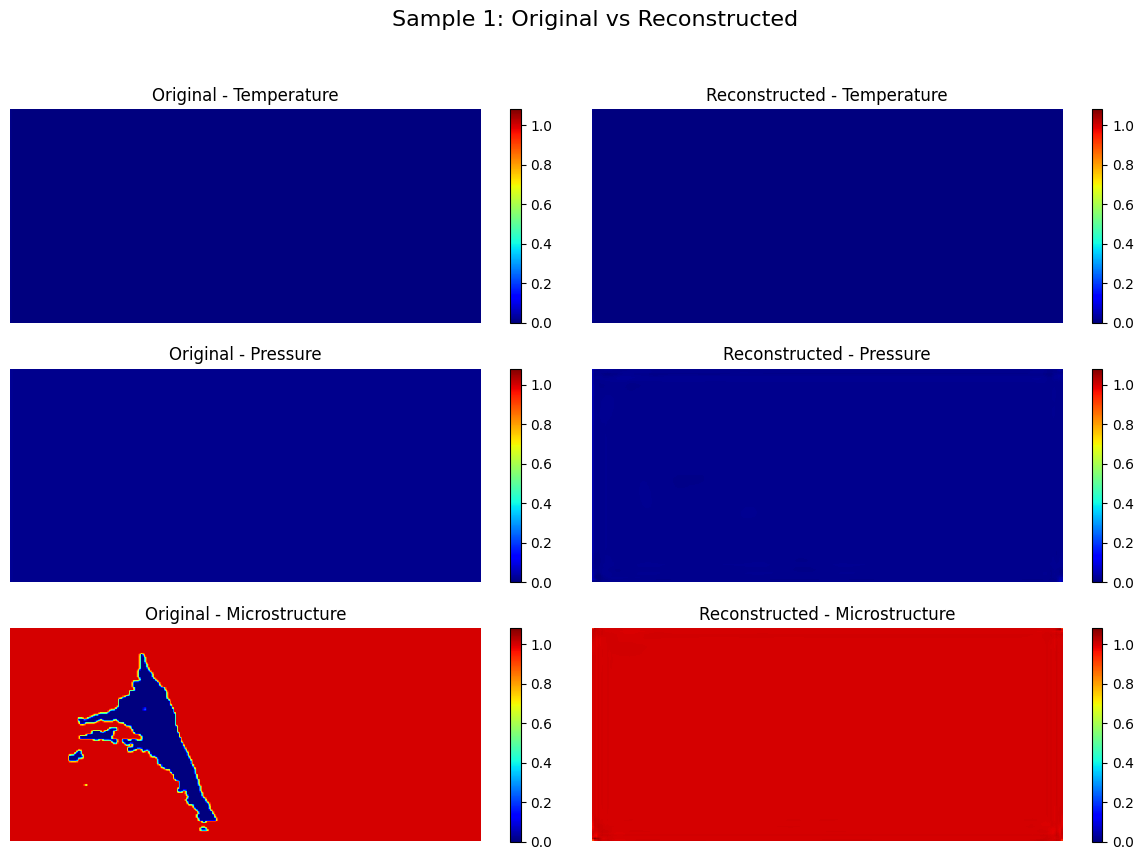

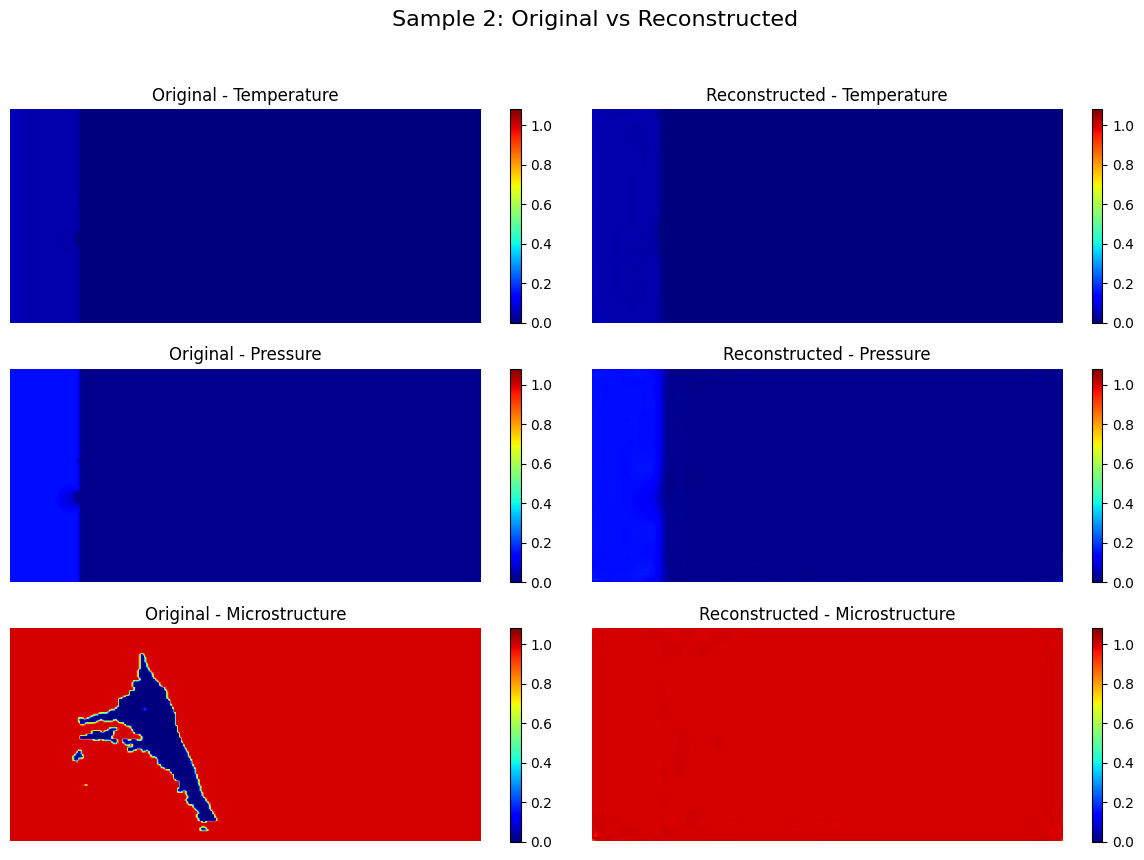

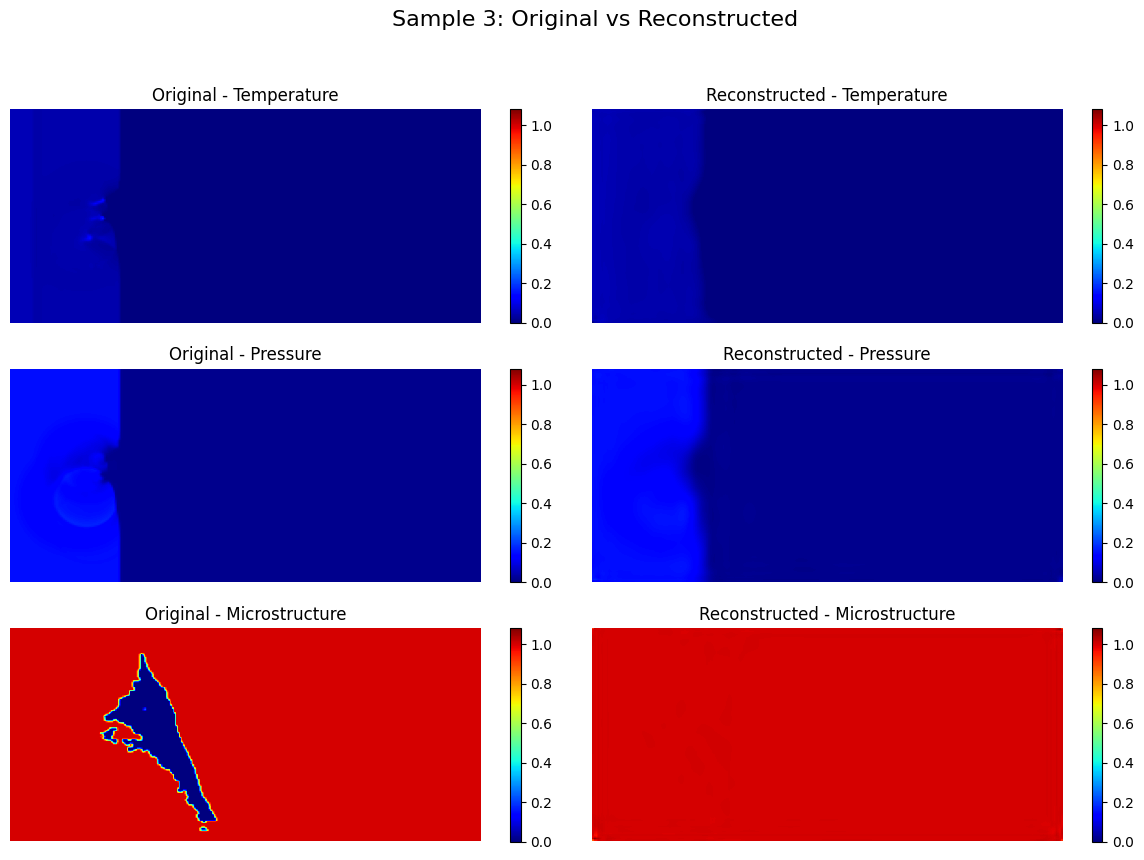

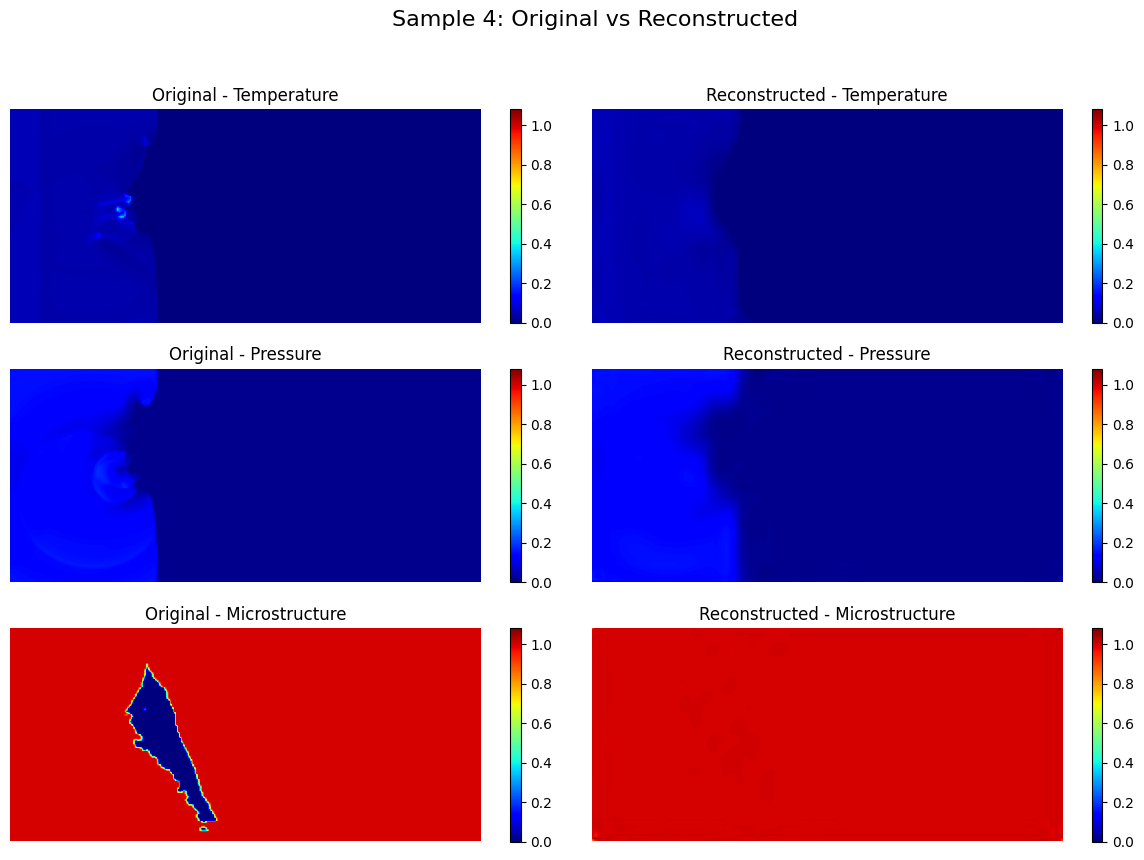

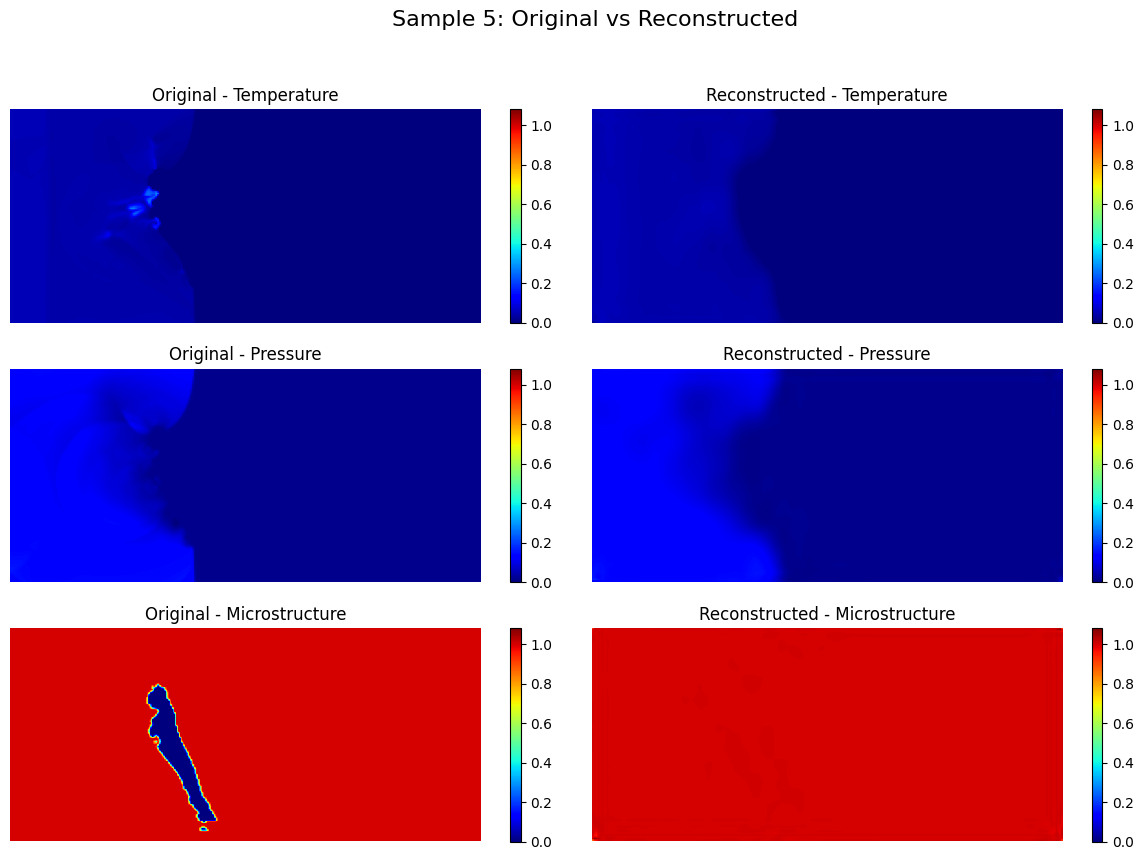

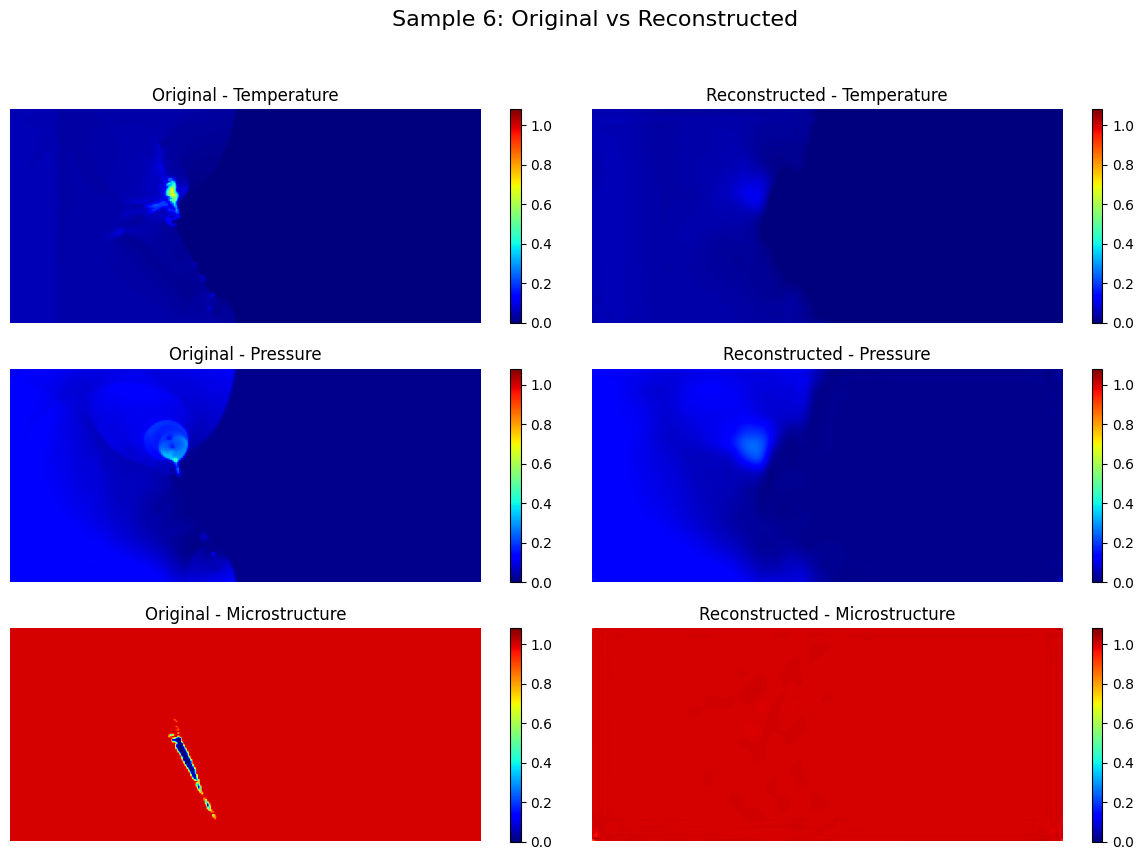

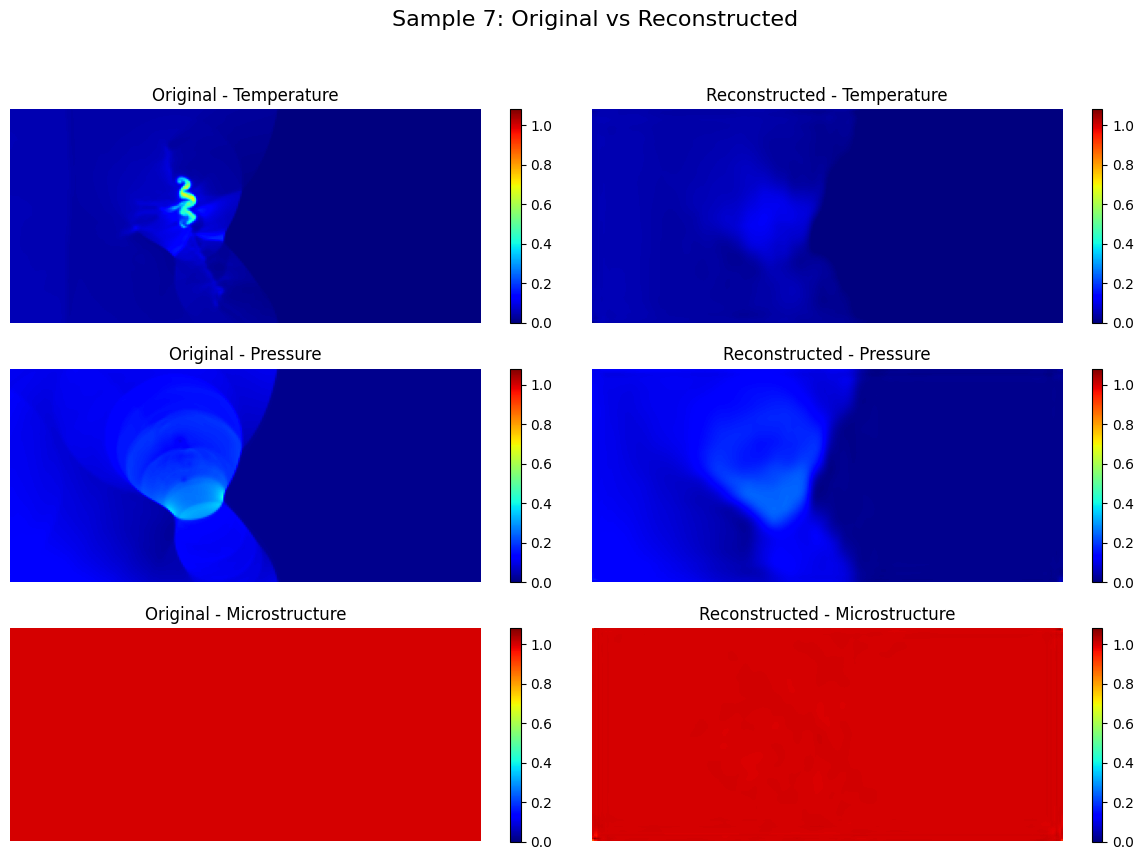

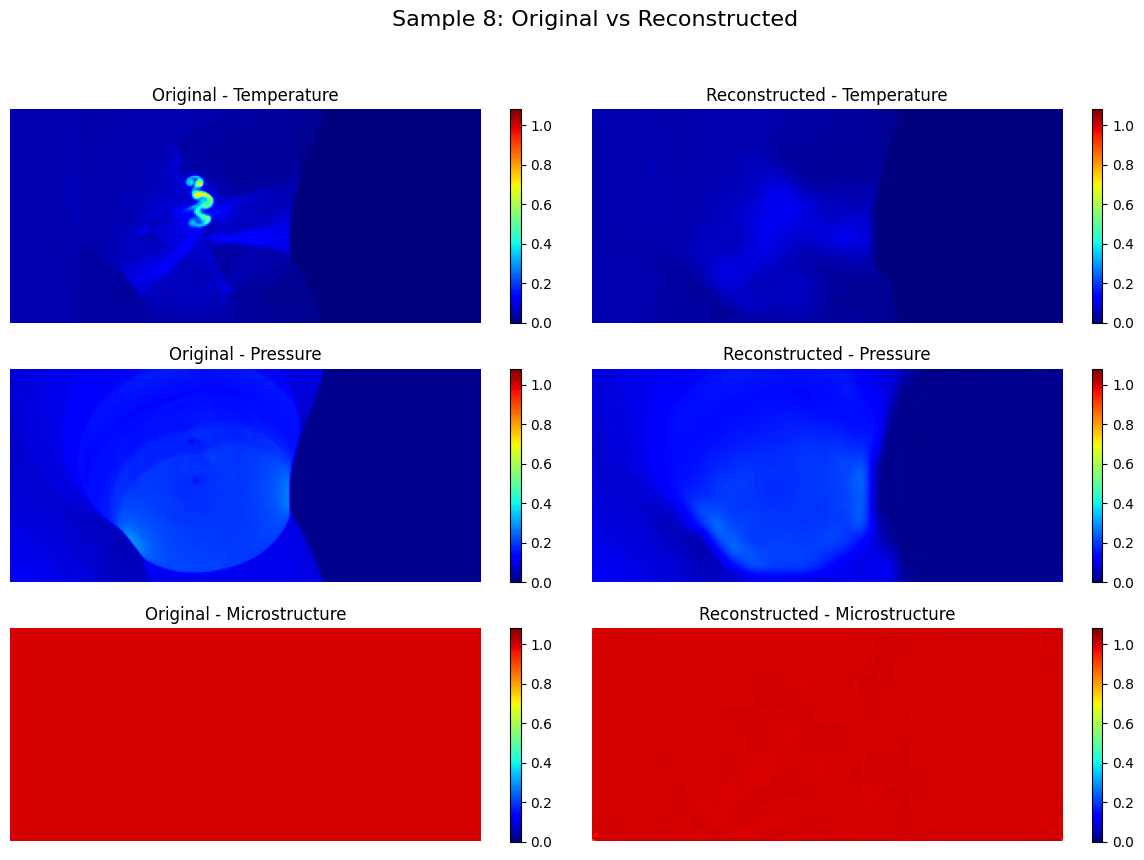

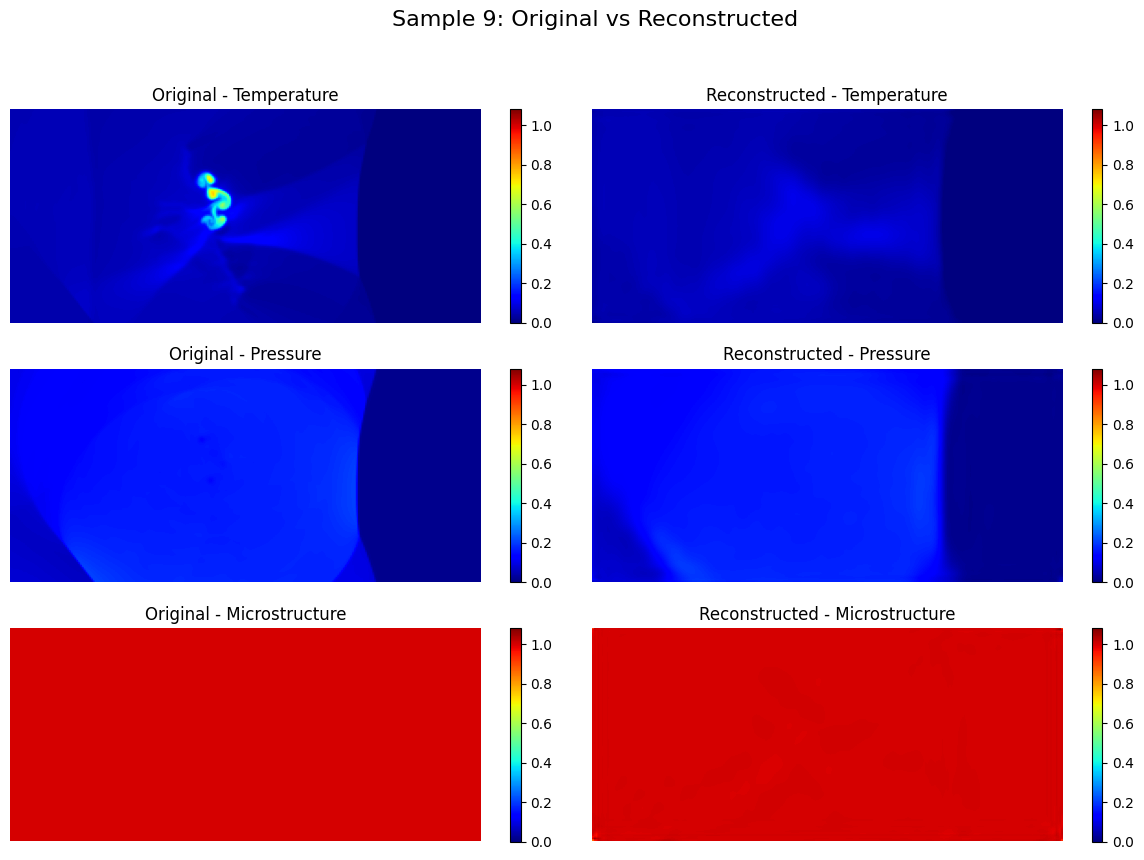

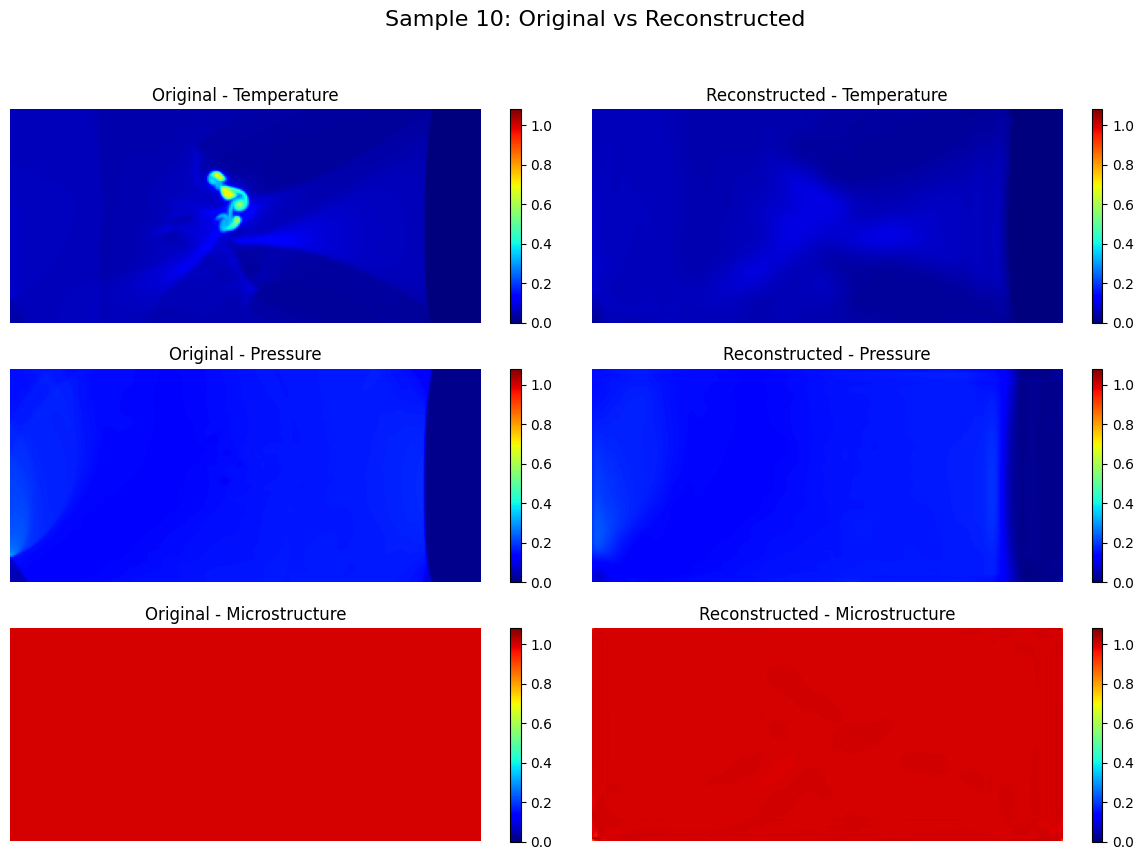

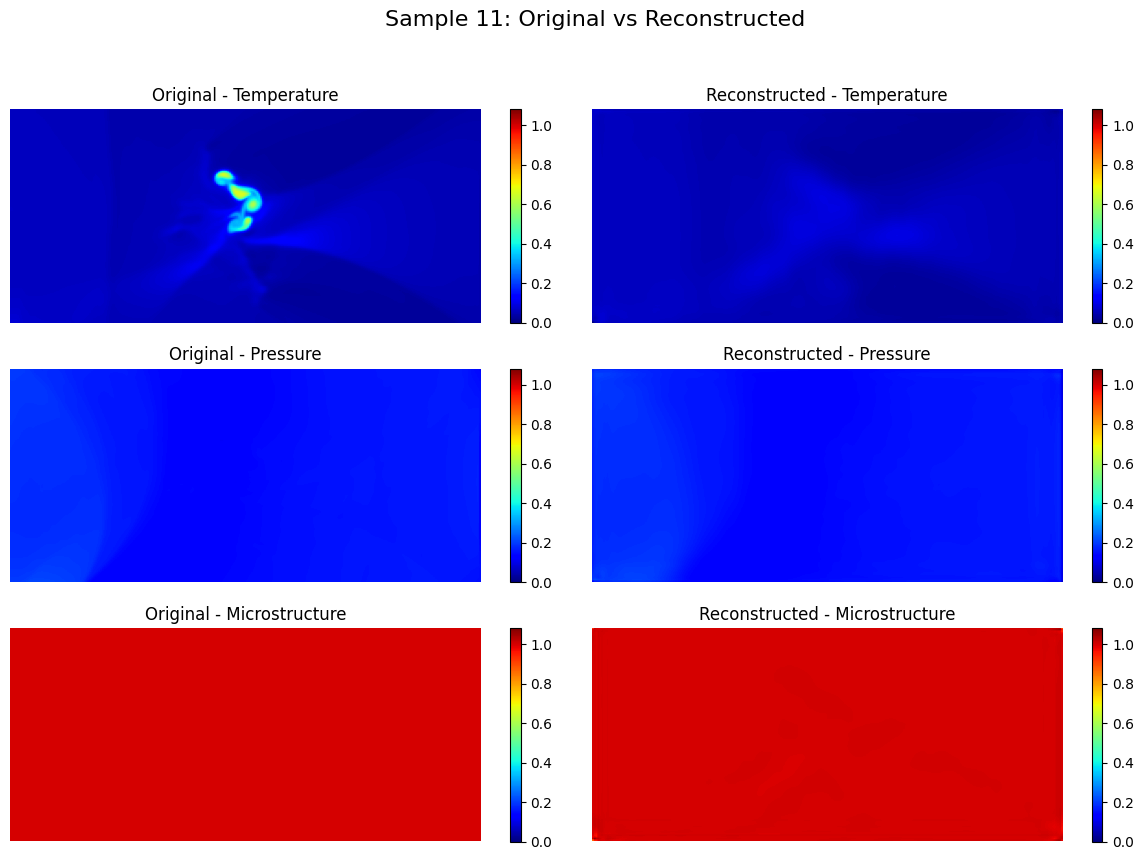

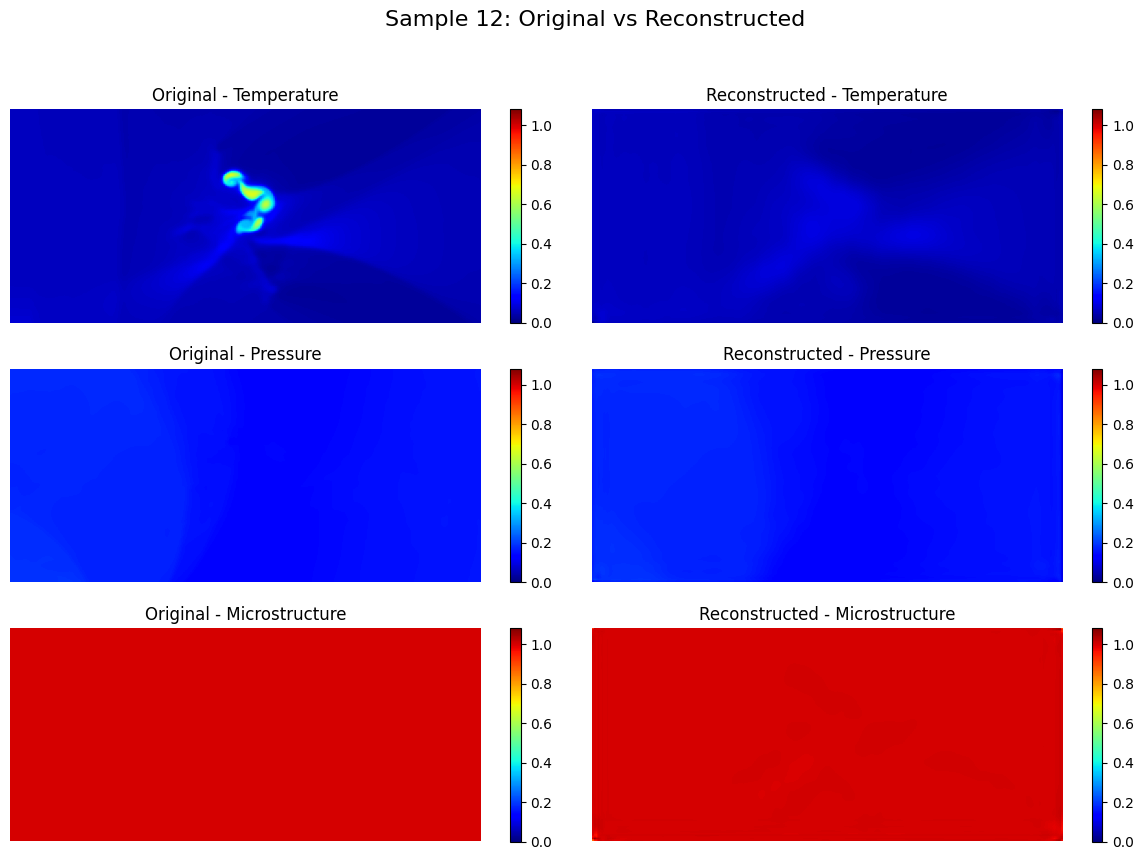

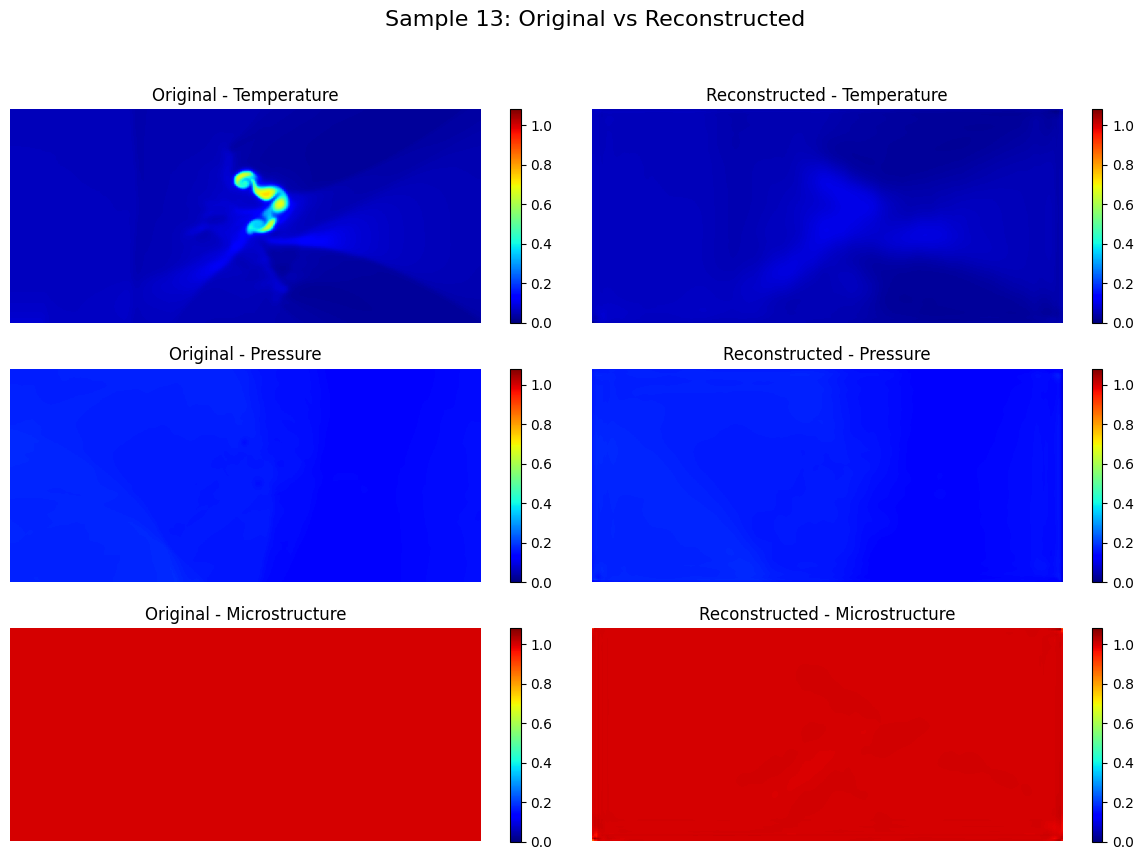

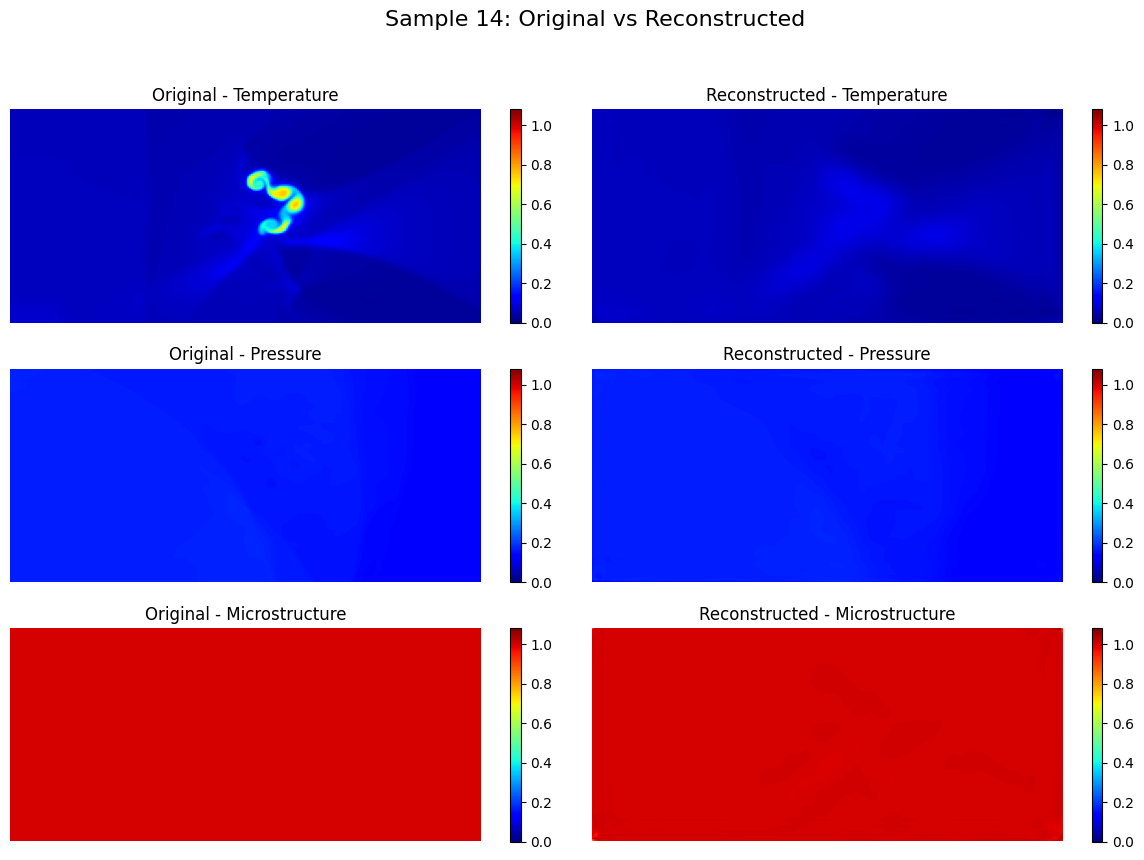

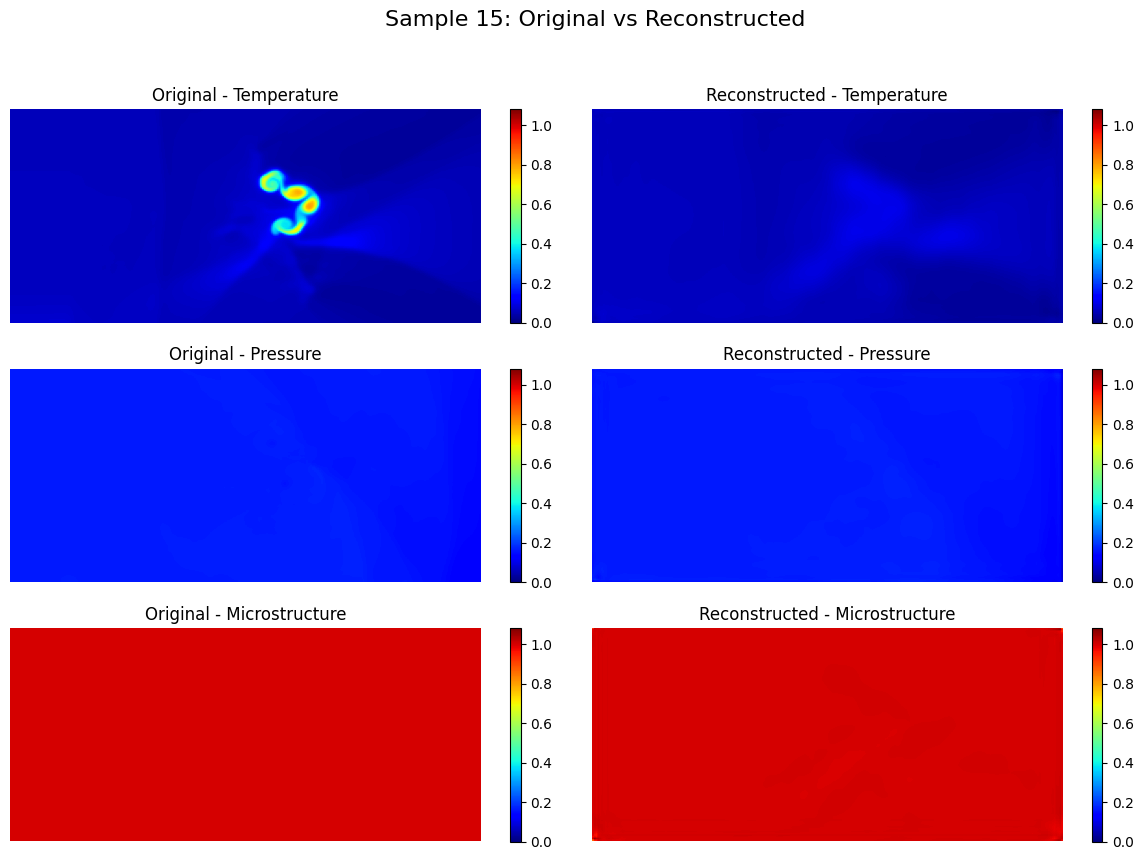

In [12]:
# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

num_samples = n_ts

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(all_test_images.min(), all_reconstructed_images.min())
global_max = max(all_test_images.max(), all_reconstructed_images.max())

# Iterate over the selected samples
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))  # 3 rows (channels) x 2 columns (original and reconstructed)
    fig.suptitle(f"Sample {sample_idx + 1}: Original vs Reconstructed", fontsize=16)
    
    # Iterate over the channels
    for channel_idx, channel_name in enumerate(channel_names):
        # Original channel
        original_channel = all_test_images[sample_idx, channel_idx, :, :].numpy()
        # Reconstructed channel
        reconstructed_channel = all_reconstructed_images[sample_idx, channel_idx, :, :].numpy()

        # Plot the original channel
        ax = axes[channel_idx, 0]
        im = ax.imshow(original_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Original - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
        
        # Plot the reconstructed channel
        ax = axes[channel_idx, 1]
        im = ax.imshow(reconstructed_channel, cmap="jet", aspect="auto", vmin=global_min, vmax=global_max)
        ax.set_title(f"Reconstructed - {channel_name}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit titles
    plt.show()


## GIFs

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

file_name = "view_loss_isoreg_1000_200"
plot_name = "L1LOSS 3 8 latent 8 AE Pred., No Dynamics, 2 Test Samples, 1000 Epochs"

# Channel names for clarity
channel_names = ["Temperature", "Pressure", "Microstructure"]

# Number of samples to show (ensure it's less than the total number of test images)
num_samples = n_ts

# Compute global min and max across all channels, all samples, and both original/reconstructed images
global_min = min(all_test_images.min(), all_reconstructed_images.min())
global_max = max(all_test_images.max(), all_reconstructed_images.max())

frames = []  # List to store frames for GIF

# Iterate over the selected samples (each sample represents a time step)
for sample_idx in range(num_samples):
    fig, axes = plt.subplots(2, 3, figsize=(6, 4), dpi=150, constrained_layout=True)  # Reduced figsize and dpi for smaller GIF
    fig.suptitle(plot_name, fontsize=12)  # Reduced font size for title
    
    for channel_idx, channel_name in enumerate(channel_names):
        original_channel = all_test_images[sample_idx, channel_idx, :, :].numpy()
        reconstructed_channel = all_reconstructed_images[sample_idx, channel_idx, :, :].numpy()
        
        # Plot original
        ax = axes[0, channel_idx]
        ax.imshow(original_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (GT)", fontsize=10)  # Smaller title font size
        ax.axis("off")
        
        # Plot reconstructed
        ax = axes[1, channel_idx]
        ax.imshow(reconstructed_channel, cmap="jet", aspect="equal", vmin=global_min, vmax=global_max, interpolation="none")
        ax.set_title(f"{channel_name} (Pred)", fontsize=10)  # Smaller title font size
        ax.axis("off")
    
    # Convert the figure to a PIL Image and append to frames
    fig.canvas.draw()  # Draw the figure onto the canvas
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))  # Reshape to image dimensions
    frames.append(Image.fromarray(img))

    plt.close(fig)

# Check if frames are created successfully
if len(frames) == 0:
    print("Error: No frames generated!")
else:
    # Save frames as GIF
    gif_path = file_name + ".gif"
    try:
        frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0)
        print(f"GIF saved to {gif_path}")
    except Exception as e:
        print(f"Error saving GIF: {e}")


/tmp/ipykernel_232470/2934278712.py:43: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


GIF saved to view_loss_isoreg_1000_200.gif


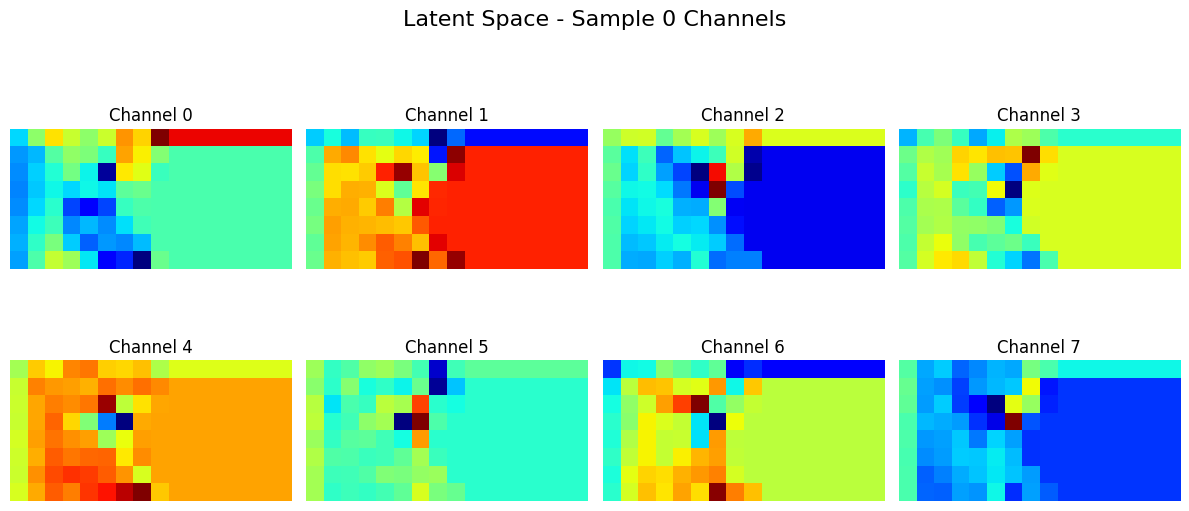

In [13]:
ts_idx = 5 # pick which time step you want to visualize

latent = model.network.encoder(all_test_images[ts_idx, ...].to(device))

latent.size()

n_channels = latent.shape[0]
n_rows, n_cols = 2, 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
fig.suptitle('Latent Space - Sample 0 Channels', fontsize=16)

for ch, ax in enumerate(axes.flat):
    img = latent[ch].detach().cpu().numpy()  # shape: [32, 64]
    im = ax.imshow(img, cmap='jet')
    ax.set_title(f'Channel {ch}')
    ax.axis('off')

plt.tight_layout()
plt.show()


## Loss Plots

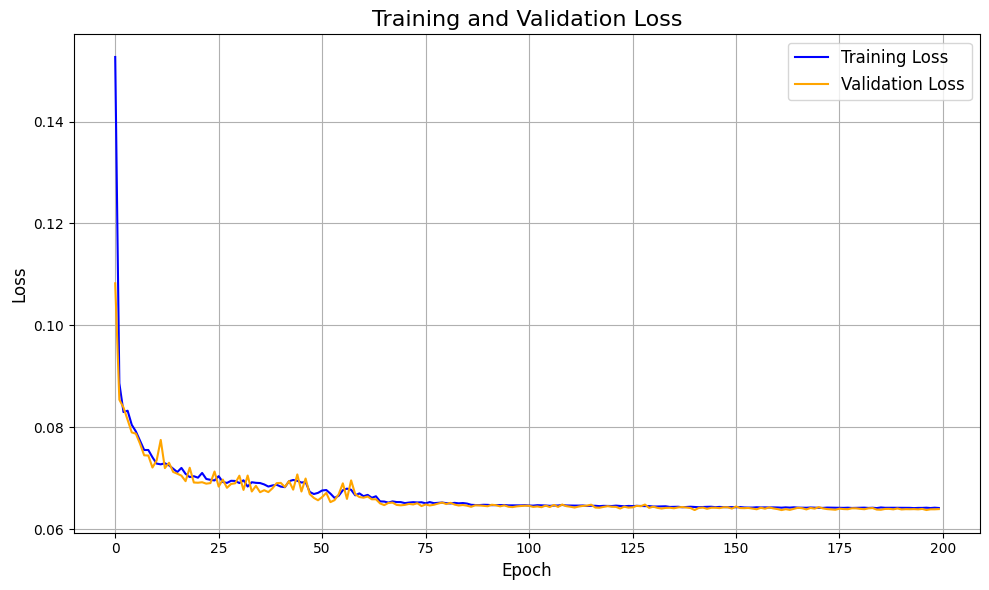

In [2]:
# Path to the JSON log file
log_file_path = "view_loss_isoreg_1000_200.json"

# Load the log data
with open(log_file_path, 'r') as f:
    log_dict = json.load(f)

# Extract training and validation loss
training_loss = log_dict['training_loss_per_epoch']
validation_loss = log_dict['validation_loss_per_epoch']

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title("Training and Validation Loss", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


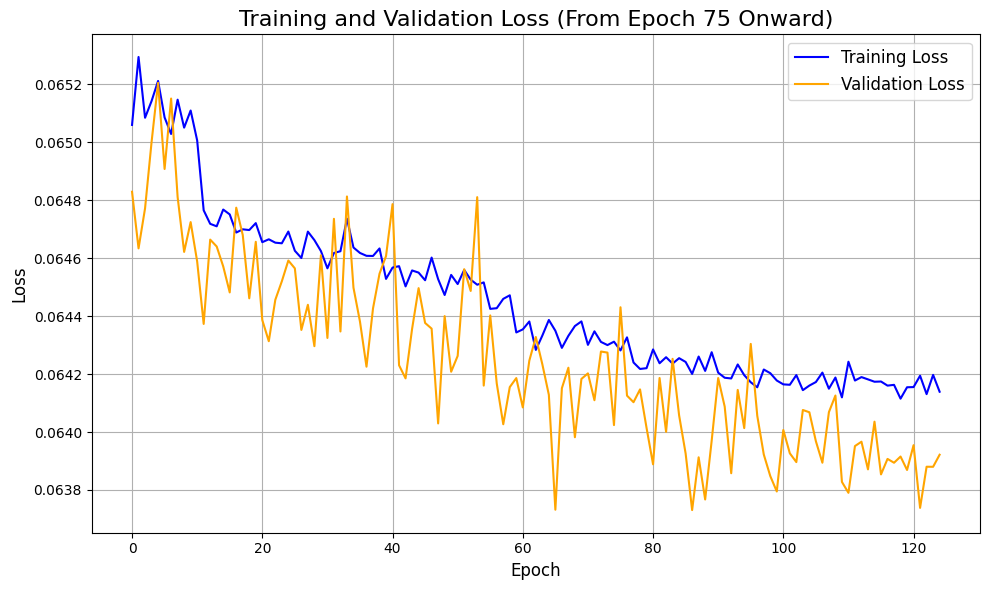

In [3]:
# Starting from the 50th epoch (index 49, since indexing starts at 0)
start_epoch = 75

# Slice the data from the 50th epoch onward
training_loss = training_loss[start_epoch:]
validation_loss = validation_loss[start_epoch:]

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
ax.plot(training_loss, label="Training Loss", color="blue")
ax.plot(validation_loss, label="Validation Loss", color="orange")

# Add titles, labels, and legend
ax.set_title(f"Training and Validation Loss (From Epoch {start_epoch} Onward)", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


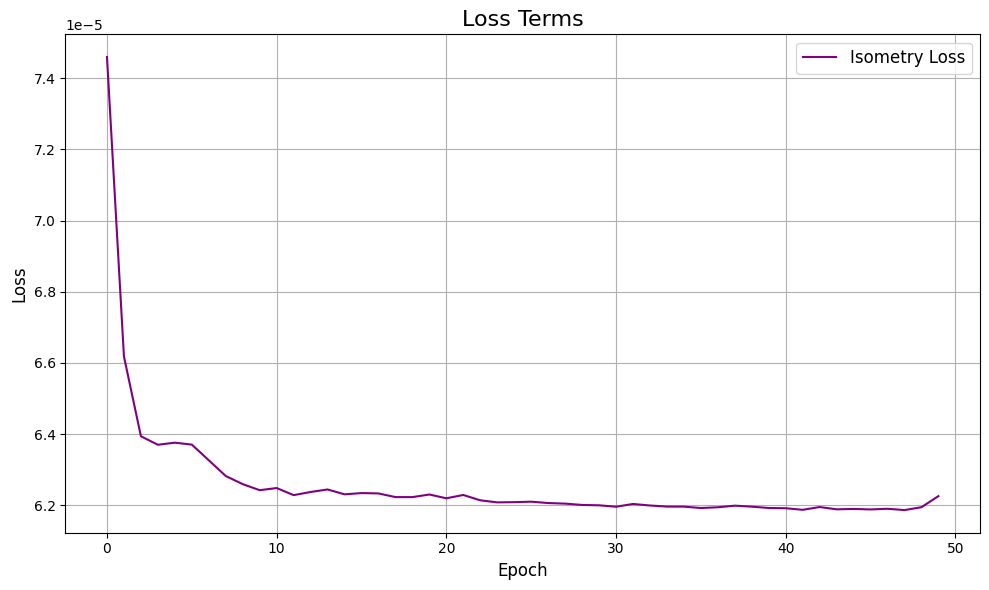

In [8]:
# Path to the JSON log file
log_file_path = "view_loss_isoreg_1000_50.json"
iso_reg = 1

# Load the log data
with open(log_file_path, 'r') as f:
    log_dict = json.load(f)

# Extract training and validation loss
training_loss = log_dict['training_loss_per_epoch']
recon_loss = log_dict['recon_loss_per_epoch']
iso_loss = [iso_reg * x for x in log_dict['iso_loss_per_epoch']]

# same plot
# Create a single plot for both training and validation loss
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation loss on the same graph
# ax.plot(training_loss, label="Total Loss", color="blue")
# ax.plot(recon_loss, label="Reconstruction Loss", color="green")
ax.plot(iso_loss, label="Isometry Loss", color="purple")

# Add titles, labels, and legend
ax.set_title("Loss Terms", fontsize=16)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [18]:
n_samples = 33

# Load in test dataset with full 15-ts sequence
n_channels = 3
n_ts = 15

# Create test dataset
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test],  # test
    future_steps=n_ts - 1,
    min_max_path=min_max_path,
)

all_X = []
all_just_AE_reconstruction = []
all_just_AE_z = []

for i in range(n_samples):
    ic, _, ts, target = test_dataset[i]
    ic = ic[:n_channels, ...]
    target = target[:, :n_channels, ...]

    # Stack input condition and target sequence into full time series
    X = torch.cat((ic.unsqueeze(0), target))  # Shape: (n_ts, C, H, W)

    just_AE_reconstruction = []
    just_AE_z = []

    for t in range(n_ts):
        IC = X[t, ...].unsqueeze(0).to(device)

        with torch.no_grad():
            # Encode (just AE) and reconstruct (AE + dynamics)
            z_nodynamics = model.network.encoder(IC)
            x_bar = model.network(IC)

        just_AE_reconstruction.append(x_bar.cpu())
        just_AE_z.append(z_nodynamics.cpu())

    # Stack each sequence over time
    just_AE_reconstruction = torch.cat(just_AE_reconstruction, dim=0)  # Shape: (n_ts-1, C, H, W)
    just_AE_z = torch.cat(just_AE_z, dim=0)  # Shape: (n_ts-1, latent_dim)

    all_X.append(X)  # Shape: (n_ts, C, H, W)
    all_just_AE_reconstruction.append(just_AE_reconstruction)
    all_just_AE_z.append(just_AE_z)

# Convert to tensors
all_X = torch.stack(all_X, dim=0)  # (n_samples, n_ts, C, H, W)
all_just_AE_reconstruction = torch.stack(all_just_AE_reconstruction, dim=0)  # (n_samples, n_ts-1, C, H, W)
all_just_AE_z = torch.stack(all_just_AE_z, dim=0)  # (n_samples, n_ts-1, latent_dim)


2025-06-05 21:53:10,201 [INFO] Starting data validation...
2025-06-05 21:53:10,203 [INFO] Validating .npy files...
Validating files: 100%|██████████| 33/33 [00:00<00:00, 725.10it/s]
2025-06-05 21:53:10,250 [INFO] Data validation completed successfully.
2025-06-05 21:53:10,251 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 33/33 [00:00<00:00, 873.45it/s]
2025-06-05 21:53:10,291 [INFO] Total samples in dataset: 33


In [19]:
all_X.shape, all_just_AE_reconstruction.shape, all_just_AE_z.shape

(torch.Size([33, 15, 3, 128, 256]),
 torch.Size([33, 15, 3, 128, 256]),
 torch.Size([33, 15, 32, 8, 16]))

In [20]:
from model_analysis import *

all_input_norm, all_latent_norm, all_reconstruction_norm = [], [], []
# all_separate_input_norm, all_separate_reconstruction_norm = [], []

for i in range(n_samples):
    X_diff = compute_finite_difference(all_X[i, ...])
    reconstruction_diff = compute_finite_difference(all_just_AE_reconstruction[i, ...])
    z_diff = compute_finite_difference(all_just_AE_z[i, ...])

    input_norm, latent_norm, reconstruction_norm = calculate_norm(X_diff, z_diff, reconstruction_diff)
    # separate_input_norm, separate_reconstruction_norm = calculate_separate_norm(X_diff, reconstruction_diff)
    
    all_input_norm.append(input_norm)
    all_latent_norm.append(latent_norm)
    all_reconstruction_norm.append(reconstruction_norm)
    
    # all_separate_input_norm.append(separate_input_norm)
    # all_separate_reconstruction_norm.append(separate_reconstruction_norm)

In [21]:
all_latent_ratio = []
all_reconstruction_ratio = []

for i in range(n_samples):  
    latent_ratio =  np.array(all_latent_norm[i]) / np.array(all_input_norm[i])
    reconstruction_ratio = np.array(all_reconstruction_norm[i]) / np.array(all_input_norm[i])
    
    all_latent_ratio.append(latent_ratio)
    all_reconstruction_ratio.append(reconstruction_ratio)

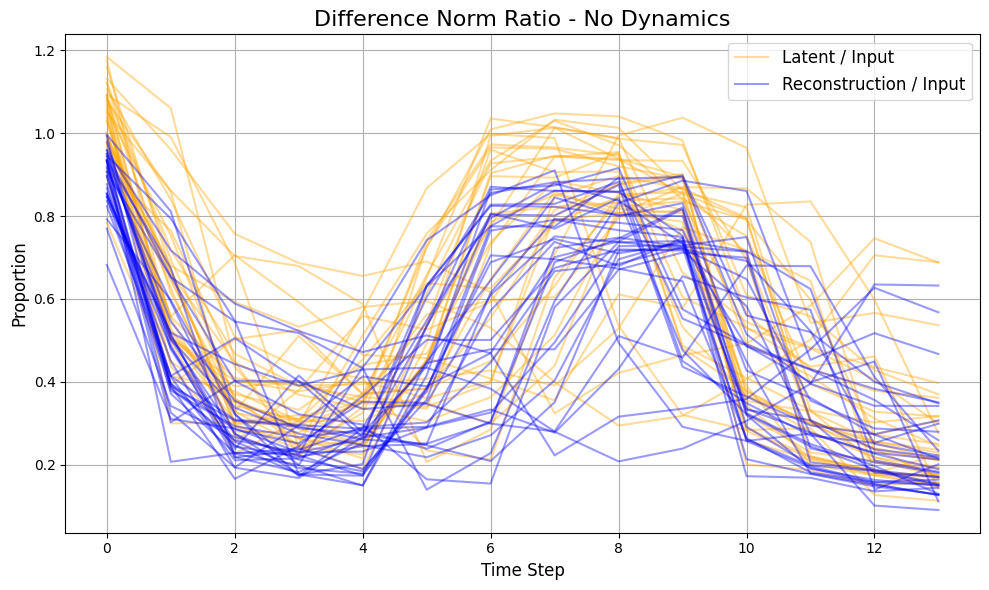

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all latent ratios (orange, 60% transparent)
for i, latent in enumerate(all_latent_ratio):
    ax.plot(latent, color="orange", alpha=0.4, label="Latent / Input" if i == 0 else None)

# Plot all reconstruction ratios (blue, 60% transparent)
for i, recon in enumerate(all_reconstruction_ratio):
    ax.plot(recon, color="blue", alpha=0.4, label="Reconstruction / Input" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Norm Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
all_input_dot, all_latent_dot, all_reconstruction_dot = [], [], []
# all_separate_input_dot, all_separate_reconstruction_dot = [], []

for i in range(n_samples):
    X_diff = compute_finite_difference(all_X[i, ...])
    reconstruction_diff = compute_finite_difference(all_just_AE_reconstruction[i, ...])
    z_diff = compute_finite_difference(all_just_AE_z[i, ...])

    input_dot = compute_pairwise_dot_product(X_diff)
    latent_dot = compute_pairwise_dot_product(z_diff)
    reconstruction_dot = compute_pairwise_dot_product(reconstruction_diff)
    # separate_input_dot = compute_pairwise_dot_product(X_diff)
    # separate_reconstruction_dot = calculate_separate_norm(X_diff, reconstruction_diff)
    
    all_input_dot.append(input_dot)
    all_latent_dot.append(latent_dot)
    all_reconstruction_dot.append(reconstruction_dot)
    
    # all_separate_input_norm.append(separate_input_norm)
    # all_separate_reconstruction_norm.append(separate_reconstruction_norm)

In [ ]:
all_latent_ratio = []
all_reconstruction_ratio = []

for i in range(n_samples):  
    latent_ratio =  np.array(all_latent_dot[i]) / np.array(all_input_dot[i])
    reconstruction_ratio = np.array(all_reconstruction_dot[i]) / np.array(all_input_dot[i])
    
    all_latent_ratio.append(latent_ratio)
    all_reconstruction_ratio.append(reconstruction_ratio)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all latent ratios (orange, 60% transparent)
for i, latent in enumerate(all_latent_ratio):
    ax.plot(latent, color="orange", alpha=0.4, label="Latent / Input" if i == 0 else None)

# Plot all reconstruction ratios (blue, 60% transparent)
for i, recon in enumerate(all_reconstruction_ratio):
    ax.plot(recon, color="blue", alpha=0.4, label="Reconstruction / Input" if i == 0 else None)

# Add titles, labels, and legend
ax.set_title("Difference Steer Ratio - No Dynamics", fontsize=16)
ax.set_xlabel("Time Step", fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)

# ax.set_ylim(-10, 10)  # Adjust range to focus on relevant data (change 0 and 2 as needed)

plt.tight_layout()
plt.show()
